# DBSCAN
This notebook uses DBSCAN as a clustering density based approach.



In [1]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler

def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else series.iloc[0]


RACES_PATH=path.join("..","dataset","engineered_races.csv")

races_df=pd.read_csv(RACES_PATH)

#print(races_df.describe())



#clustering_data=clustering_data.drop(columns=["date","difficulty_level"])
#print(races_df.info())
clustering_data=races_df.groupby(['date','stage','std_name','cyclist']).agg({
    'profile':most_frequent,
    'is_tarmac':most_frequent,
    'difficulty_level':most_frequent,

    'points':'sum',

    'length':'mean',
    'climb_total':'mean',
    'competitive_age':'mean',
    'startlist_quality':'mean',
    'delta':'mean',
    'performance_index':'mean',
    'difficulty':'mean',
    'convenience_score':'mean',
    'difficulty_score':'mean',
    'gain_ratio':'mean',

    'cyclist_age':'first',
    'position':'first',
    'cyclist_team':'first',
}).reset_index()

print(clustering_data)

#clustering_data=races_df[cols].copy()
#convert to timestamp(units are useless since it's getting normalized)
clustering_data['date']=pd.to_datetime(clustering_data['date'])
clustering_data['day']=clustering_data['date'].dt.day
clustering_data['month']=clustering_data['date'].dt.month
clustering_data['year']=clustering_data['date'].dt.year

#one hot encoding difficulty
ohe_diff_lvl=pd.get_dummies(races_df['difficulty_level']).astype(float)

#clustering_data
dec_cut=pd.date_range(
    start=clustering_data['date'].min(),
    end=clustering_data['date'].max(),
    freq='10YE'
)
clustering_data['decade']=pd.cut(
    clustering_data['date'],
    bins=dec_cut,
)

clustering_data[ohe_diff_lvl.columns]=ohe_diff_lvl

clustering_data=clustering_data.drop(columns="date")



              date   stage               std_name  \
0       1970-02-28  result  omloop-het-nieuwsblad   
1       1970-02-28  result  omloop-het-nieuwsblad   
2       1970-02-28  result  omloop-het-nieuwsblad   
3       1970-02-28  result  omloop-het-nieuwsblad   
4       1970-02-28  result  omloop-het-nieuwsblad   
...            ...     ...                    ...   
589734  2023-07-29  result          san-sebastian   
589735  2023-07-29  result          san-sebastian   
589736  2023-07-29  result          san-sebastian   
589737  2023-07-29  result          san-sebastian   
589738  2023-07-29  result          san-sebastian   

                            cyclist  profile  is_tarmac difficulty_level  \
0                    andre-dierickx      3.0      False         moderate   
1                 christian-callens      3.0      False         moderate   
2              daniel-van-ryckeghem      3.0      False         moderate   
3                       eddy-merckx      3.0      False    

Note: before starting, for reasons of time we could,for this delivery, do the clustering on the full dataset so for now we decided to employ some sort of data reduction as to make it feasible to run such an algorithm

# clustering organization

For reasons of time using DBSCAN on the whole dataset is not feasible, a second approach would be to try and a segmentation, for this part we wanted to employ a clusterization that is time based and analyses clusters across decades and see what we can find.

In [2]:
import numpy as np
import random




def random_sampling_reduce(data,reduction_percent):
    num_samples=data.shape[0]

    reduction_num_samples=int(np.ceil(reduction_percent*num_samples))

    RANDOM_SEED=42

    np.random.seed(RANDOM_SEED)

    reduction_idx=np.random.choice(range(len(clustering_data)),reduction_num_samples,replace=False)

    return data.iloc[reduction_idx]



A few notes are due before starting, first the eps are difficulty to setup for now a good strategy would be to take inspiration using the first paper the introduced the algorithm, which you can find [here](https://dl.acm.org/doi/10.5555/3001460.3001507), and use the distance from the k-th NN varying K until we find a good eps value for us.



In [3]:
from sklearn.metrics import silhouette_score
import itertools as it
import numpy as np
import utils

Given that we have highly dimensional features just trying the values isn't enough. A good idea would be to use a KNN and the elbow method to estimate the correct eps value. We still need to do some kind of aggregation before.




## applying the elbow method
so given the unfeasibility of using the whole dataset for this part we divide everything going from decade to decade.

Index(['profile', 'points', 'length', 'climb_total', 'competitive_age',
       'startlist_quality', 'delta', 'performance_index', 'difficulty',
       'convenience_score', 'difficulty_score', 'gain_ratio', 'cyclist_age',
       'position', 'day', 'month', 'year', 'decade'],
      dtype='object')
{Interval(1970-12-31 00:00:00, 1980-12-31 00:00:00, closed='right'): 13920, Interval(1980-12-31 00:00:00, 1990-12-31 00:00:00, closed='right'): 54241, Interval(1990-12-31 00:00:00, 2000-12-31 00:00:00, closed='right'): 98771, Interval(2000-12-31 00:00:00, 2010-12-31 00:00:00, closed='right'): 177791, Interval(2010-12-31 00:00:00, 2020-12-31 00:00:00, closed='right'): 188772}
(1970-12-31 00:00:00, 1980-12-31 00:00:00]
17


/tmp/ipykernel_41482/2884938534.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dec_groups=clustering_data.groupby('decade')


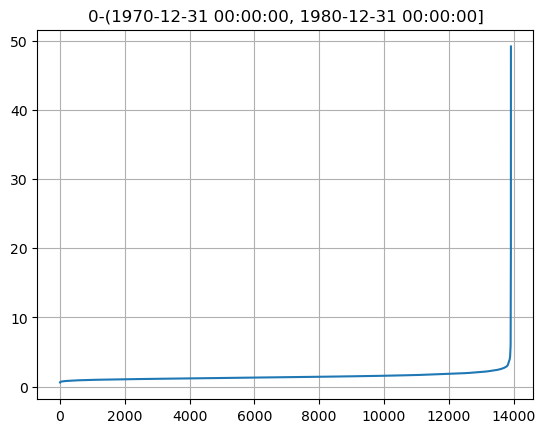

(1980-12-31 00:00:00, 1990-12-31 00:00:00]
17


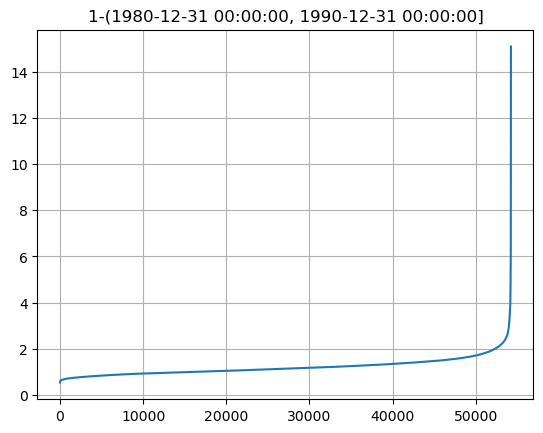

(1990-12-31 00:00:00, 2000-12-31 00:00:00]
17


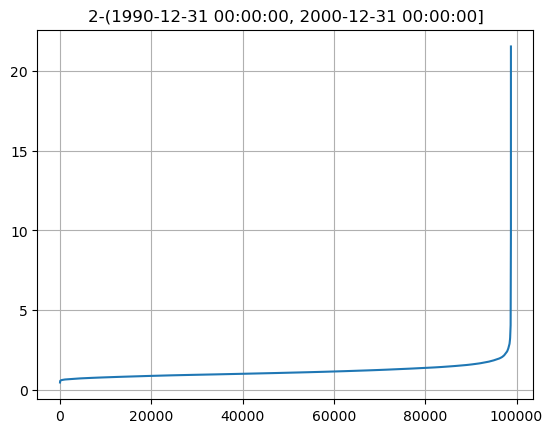

(2000-12-31 00:00:00, 2010-12-31 00:00:00]
17


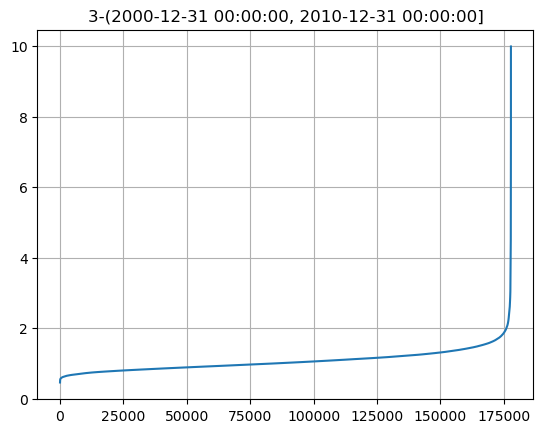

(2010-12-31 00:00:00, 2020-12-31 00:00:00]
17


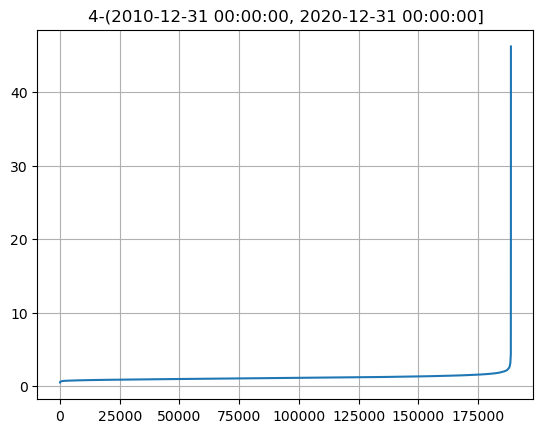

: 

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
clustering_data=clustering_data.drop(columns=["difficulty_level","stage","std_name","cyclist","cyclist_team","easy","hard","moderate","is_tarmac"]).drop_duplicates()

#clustering_data=random_sampling_reduce(clustering_data,1)

std_scaler=StandardScaler()

print(clustering_data.columns)

dec_groups=clustering_data.groupby('decade')
normalized_decade_groups={k:std_scaler.fit_transform(g.drop(columns="decade").drop_duplicates()) for k,g in dec_groups }

print({k:len(g) for k,g in normalized_decade_groups.items()})


for i,(k,data) in enumerate(normalized_decade_groups.items()):
    print(f"{k}")
    min_pts=data.shape[1]
    print(min_pts)
    nn=NearestNeighbors(n_neighbors=min_pts-1,n_jobs=-1)
    nn.fit(data)
    distances,indices= nn.kneighbors(data)
    k_distances= np.sort(distances[:, -1])
    x=plt.gca().get_xticks()
    y=plt.gca().get_yticks()
    plt.title(f"{i}-{k}")
    plt.plot(k_distances)
    plt.grid(True)
    plt.show()


Now that we have the sorted distances we can pick the eps values and proceed to test dbscan , in this case we have more starting eps values given the segmentation hance we have a lot of tests to do.

In [ ]:

from sklearn.metrics import pairwise_distances

eps_values=[2,3,3,10,50]
group_eps_values={k:v for k,v in zip(normalized_decade_groups.keys(),eps_values)}
# useful for reference
db_scan_mapping={
    -1:'noisy',
    0:'border',
    1:'core'

}

std_scaler=StandardScaler()

group_results=pd.DataFrame()


for k,eps in group_eps_values.items():
    print(k,eps)
    decade_data=normalized_decade_groups[k]
    precomp_dists=pairwise_distances(decade_data,metric='euclidean')
    #NOTE: this might have to be revisited for it's just to try if everyting works
    dimension=decade_data.shape[1]
    min_pts=int(dimension-1)
    #using the method seen at laboratory to select initial values
    #print(decade_data.drop(columns="decade").info())
    maximum_distance = abs(decade_data.max() - decade_data.min()).sum().item()
    average_concentration = dimension / maximum_distance
    #use diferent scales for eps values
    eps_values=eps * np.array([10, 5, 2.5, 1])
    #try various metrics
    metrics=['euclidean']

    min_pts_values=[min_pts]
    print(
    f"""
    group no.{k}

    average concentration:{average_concentration}

    eps values:{eps_values}

    used metrics:{metrics}

    number of minimum samples:{min_pts}

    number of samples used:{decade_data.shape[0]}
    """
    )
    #normalization is done for each group
    result=utils.run_dbscan(min_pts_values,eps_values,metrics,decade_data,precomp_dists)
    result["group"]=k

    group_results=pd.concat([group_results,result])
    print(result.sort_values(by='silhoutte_score'))
group_results.sort_values(by='silhoutte_score')

(1970-12-31 00:00:00, 1980-12-31 00:00:00] 2

    group no.(1970-12-31 00:00:00, 1980-12-31 00:00:00]

    average concentration:0.2800997979105534

    eps values:[20. 10.  5.  2.]

    used metrics:['euclidean']

    number of minimum samples:16

    number of samples used:13920
    
starting 0
 {'index': 0, 'eps': 20.0, 'min_samples': 16}
(array([-1,  0]), array([    1, 13919]))
finished
 index                    0.0
eps                     20.0
metric             euclidean
min_samples             16.0
silhoutte_score     0.904684
Name: 0, dtype: object
starting 1
 {'index': 1, 'eps': 10.0, 'min_samples': 16}
(array([-1,  0]), array([    3, 13917]))
finished
 index                    1.0
eps                     10.0
metric             euclidean
min_samples             16.0
silhoutte_score     0.852186
Name: 0, dtype: object
starting 2
 {'index': 2, 'eps': 5.0, 'min_samples': 16}
(array([-1,  0]), array([    8, 13912]))
finished
 index                    2.0
eps                      

In [ ]:
best_idx=group_results['silhoutte_score'].argmax()
best_params=group_results.iloc[best_idx]
best_eps=best_params['eps']
best_metric=best_params['metric']

best_dbscan=DBSCAN(eps=best_eps,metric=best_metric,min_samples=min_pts).fit(reduction_data)

labels=best_dbscan.labels_

statistics=np.unique(best_dbscan.labels_,return_counts=True)

print(f"""
results:{best_params}
statistics:
    raw counts:{statistics}
    percentags:{statistics/np.sum(statistics)}
"""
)


- segmentazione sui migliori o per anni
- rifare per altri in caso
- plot BSS e SSE sì
- aggregazione gare sì